In [3]:
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from imageio import imread, imwrite

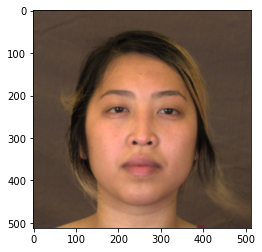

In [4]:
im = imread('/data/datasets/Turbulence/Tubfaces95/references/03.png')
plt.imshow(im)

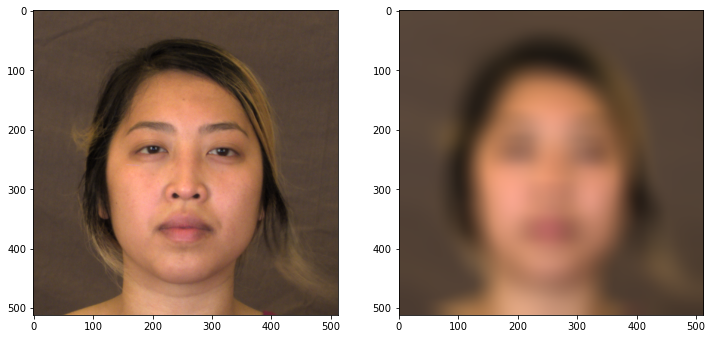

In [31]:
import math
import cv2
from basicsr.data import degradations as degradations
kernel = degradations.random_mixed_kernels(
    ['iso', 'aniso'],
    [0.5, 0.5],
    int(np.random.uniform(25, 25)) * 2 + 1,
    [20, 20.1],
    [20, 20.1], [-math.pi, math.pi],
    noise_range=None)
dim = cv2.filter2D(im, -1, kernel)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(im)

plt.subplot(122)
plt.imshow(dim)